In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import random

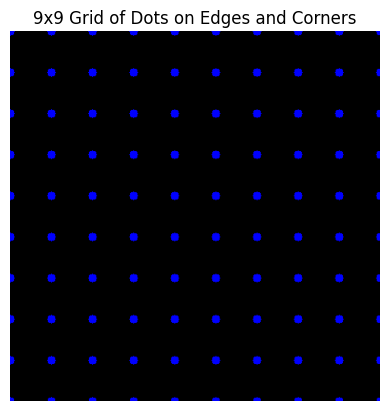

True

In [31]:
# Define the grid size
grid_size = 9

# Define the spacing between the dots
spacing = 50

# Create a blank image
grid_image = np.zeros((spacing * (grid_size), spacing * (grid_size), 3), dtype=np.uint8)

# Draw the grid of dots on the edges and corners
for i in range(grid_size + 1):
    for j in range(grid_size + 1):
        x = spacing * i
        y = spacing * j
        cv2.circle(grid_image, (x, y), 5, (255, 0, 0), -1)  # Red dots

# Display the result using plt.imshow
plt.imshow(cv2.cvtColor(grid_image, cv2.COLOR_BGR2RGB))
plt.title(f"{grid_size}x{grid_size} Grid of Dots on Edges and Corners")
plt.axis('off')
plt.show()

# Save the grid image as reference_chessboard
reference_chessboard_path = 'reference_chessboard.png'
cv2.imwrite(reference_chessboard_path, grid_image)

C:\Users\danim\AppData\Local\Temp\ipykernel_9184\1962603616.py:81: RuntimeWarning: overflow encountered in scalar multiply
  return a[0] * b[1] - a[1] * b[0]


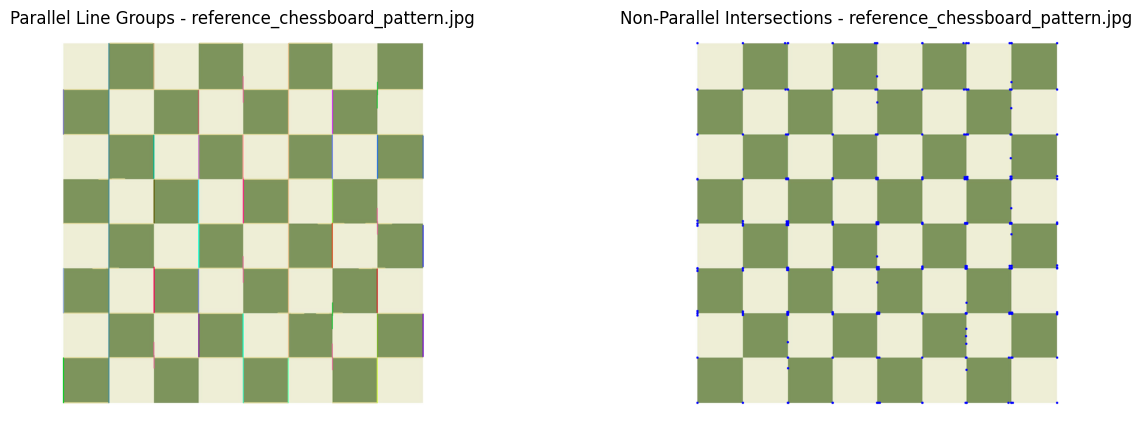

Number of reference corners: 81


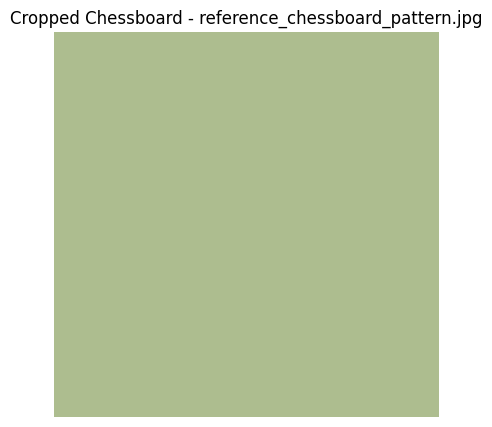

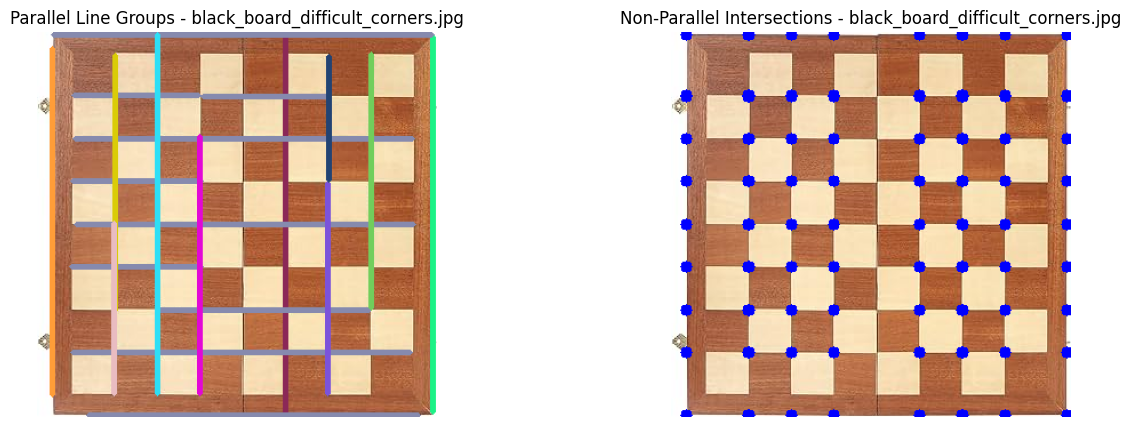

Number of reference corners: 81


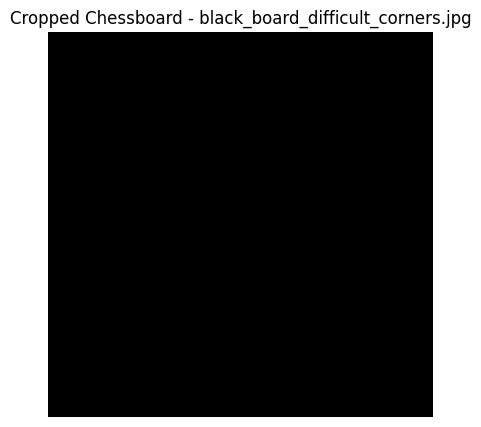

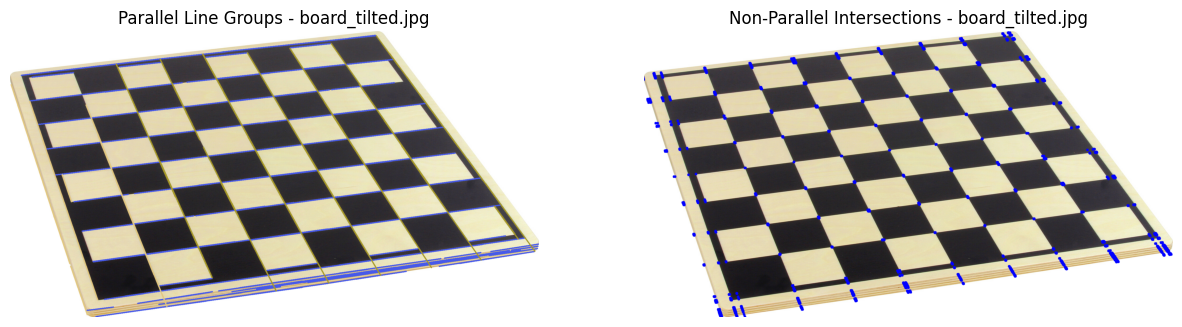

Number of reference corners: 81


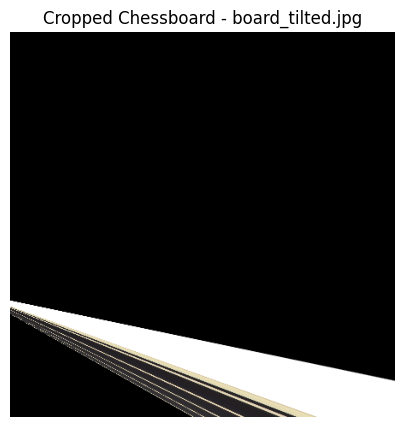

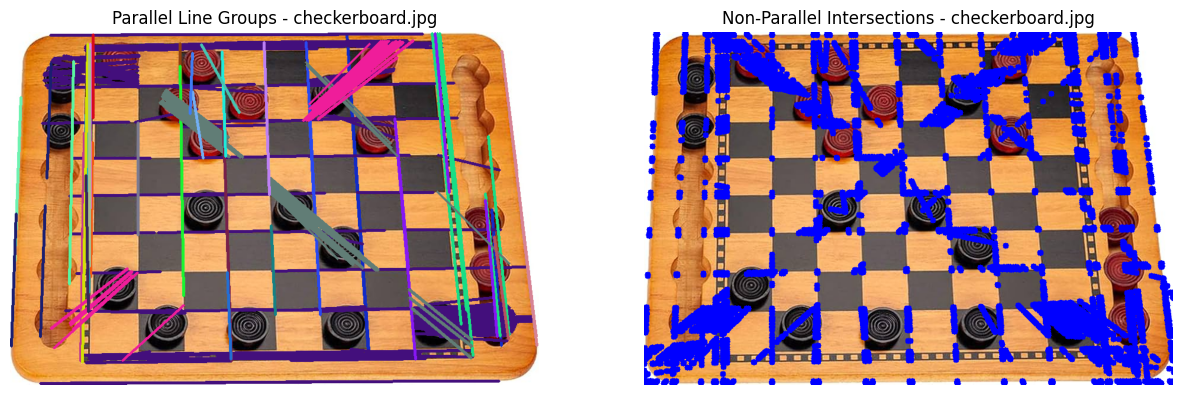

Number of reference corners: 81


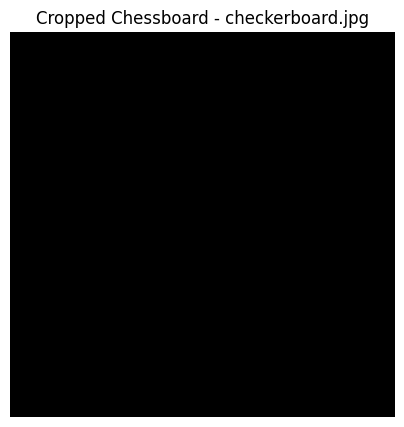

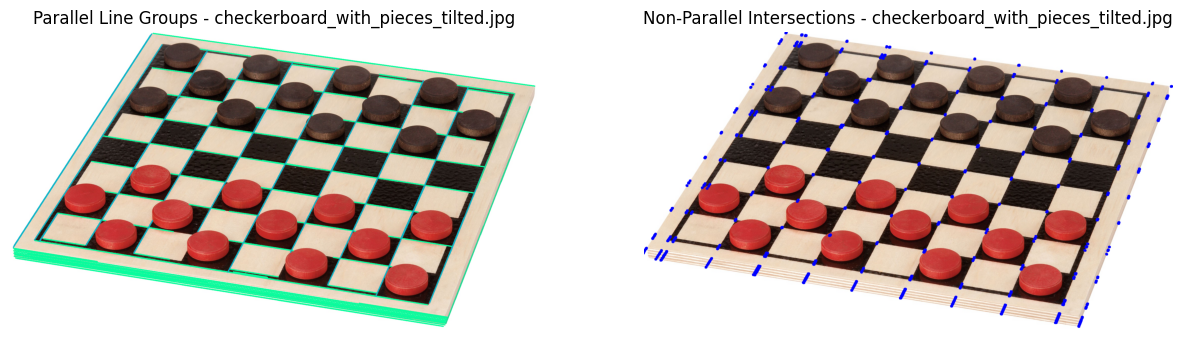

Number of reference corners: 81


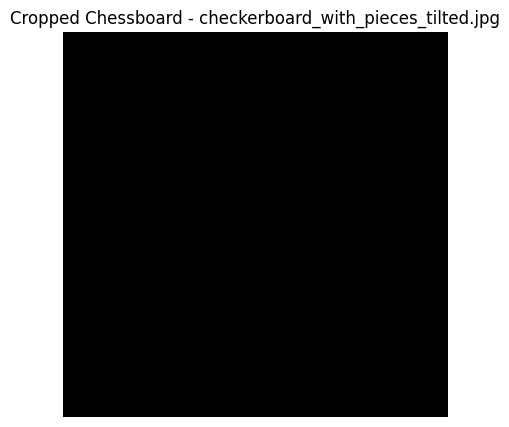

C:\Users\danim\AppData\Local\Temp\ipykernel_9184\1962603616.py:81: RuntimeWarning: overflow encountered in scalar subtract
  return a[0] * b[1] - a[1] * b[0]


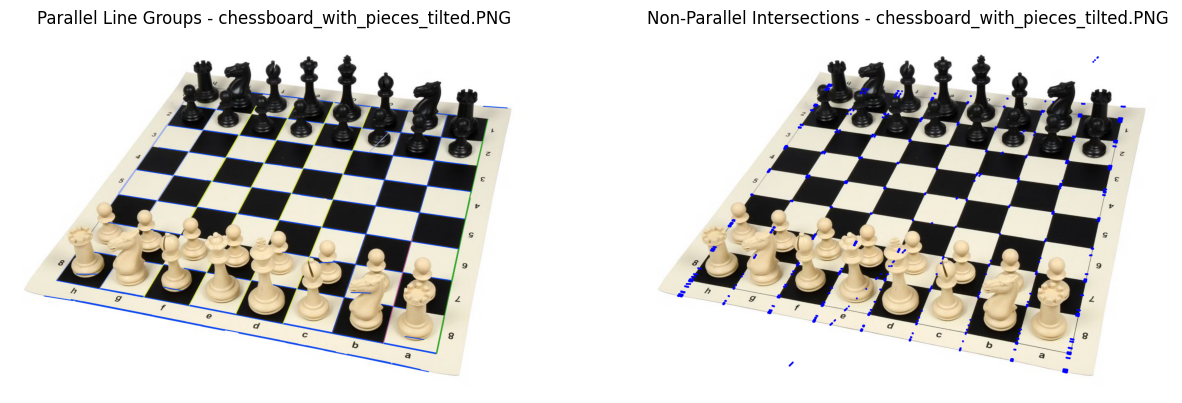

Number of reference corners: 81


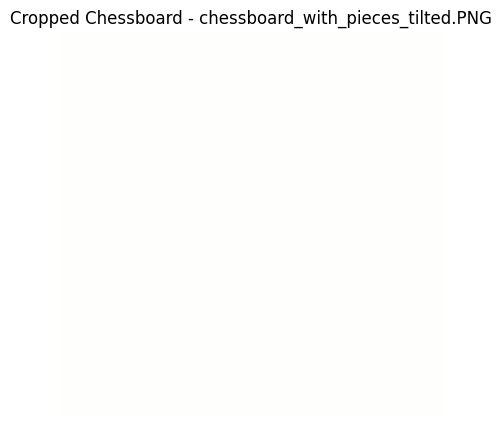

In [33]:
#iterative closest point between the points we want to find and the points we haven't found
# Plenty of code that does iterative closest point in python. Use a template and modify it to fit our needs

# List of image paths
image_paths = [
    'data/boards/reference_chessboard_pattern.jpg',
    'data/boards/black_board_difficult_corners.jpg',
    'data/boards/board_tilted.jpg',
    'data/checkerboards/checkerboard.jpg',
    'data/checkerboards/checkerboard_with_pieces_tilted.jpg',
    'data/chessboard/chessboard_with_pieces_tilted.PNG'
]

for image_path in image_paths:
    # 1. Read the image
    image = cv2.imread(os.path.relpath(image_path), cv2.IMREAD_COLOR)

    # 2. Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 3. Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # 4. Perform edge detection using the Canny edge detector
    edges = cv2.Canny(blurred, 50, 150)

    # 5. Use the Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=80, minLineLength=100, maxLineGap=30)

    # Ensure lines are detected
    if lines is None:
        print(f"No lines detected in {image_path}.")
        continue

    # 6. Function to calculate slope of a line
    def calculate_slope(x1, y1, x2, y2):
        if x2 - x1 != 0:
            return (y2 - y1) / (x2 - x1)
        else:
            return np.inf  # Vertical lines have infinite slope

    # 7. Group lines that are parallel by slope
    def group_parallel_lines(lines, slope_threshold=0.6):
        groups = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            slope = calculate_slope(x1, y1, x2, y2)
            added = False
            for group in groups:
                group_slope = calculate_slope(group[0][0], group[0][1], group[0][2], group[0][3])
                if abs(slope - group_slope) < slope_threshold:
                    group.append(line[0])
                    added = True
                    break
            if not added:
                groups.append([line[0]])
        return groups

    # 8. Group parallel lines
    parallel_groups = group_parallel_lines(lines)

    # 9. Display lines in different colors for each group
    grouped_image = image.copy()
    colors = []

    # Generate random colors for each group
    for _ in range(len(parallel_groups)):
        colors.append([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)])

    for i, group in enumerate(parallel_groups):
        for line in group:
            x1, y1, x2, y2 = line
            cv2.line(grouped_image, (x1, y1), (x2, y2), colors[i], thickness=4)

    # 10. Function to find intersection points between two lines
    def line_intersection(line1, line2):
        xdiff = (line1[0] - line1[2], line2[0] - line2[2])
        ydiff = (line1[1] - line1[3], line2[1] - line2[3])

        def det(a, b):
            return a[0] * b[1] - a[1] * b[0]

        div = det(xdiff, ydiff)
        if div == 0:
            return None  # Parallel lines

        d = (det((line1[0], line1[1]), (line1[2], line1[3])), 
             det((line2[0], line2[1]), (line2[2], line2[3])))
        x = det(d, xdiff) / div
        y = det(d, ydiff) / div
        return int(x), int(y)

    # 11. Find intersections between non-parallel lines only
    intersections = []
    for i, group1 in enumerate(parallel_groups):
        for line1 in group1:
            for j, group2 in enumerate(parallel_groups):
                if i != j:  # Avoid checking within the same group
                    for line2 in group2:
                        intersection = line_intersection(line1, line2)
                        if intersection:
                            intersections.append(intersection)

    # 12. Draw intersections as red dots on the original image
    intersections_image = image.copy()
    blank_image = np.zeros_like(image)
    for intersection in intersections:
        cv2.circle(intersections_image, intersection, 5, (255, 0, 0), -1)  # Red for intersections
        cv2.circle(blank_image, intersection, 5, (255, 0, 0), -1)  # Red for intersections on blank image

    # Save the blank image with intersections
    output_dir = 'output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    blank_image_path = os.path.join(output_dir, f'blank_{os.path.basename(image_path)}')
    cv2.imwrite(blank_image_path, blank_image)


    # 13. Display the result with intersections
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(grouped_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f"Parallel Line Groups - {os.path.basename(image_path)}")
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(intersections_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title(f"Non-Parallel Intersections - {os.path.basename(image_path)}")
    axs[1].axis('off')


    plt.show()
    # Generate synthetic reference chessboard corners
    def generate_synthetic_corners(grid_size, spacing):
        corners = []
        for i in range(grid_size):
            for j in range(grid_size):
                corners.append((j * spacing, i * spacing))
        return corners

    # Generate synthetic reference corners
    reference_corners = generate_synthetic_corners(9, 50)

    print("Number of reference corners:", len(reference_corners))

    # Function to apply ICP and find the transformation matrix
    def apply_icp(source_points, target_points):
        source_points = np.array(source_points, dtype=np.float32)
        target_points = np.array(target_points, dtype=np.float32)
        retval, inliers = cv2.estimateAffinePartial2D(source_points, target_points)
        return retval

    # Apply ICP to align detected intersections with synthetic reference chessboard corners
    if len(intersections) >= len(reference_corners):
        icp_transform = apply_icp(intersections[:len(reference_corners)], reference_corners)

        if icp_transform is not None:
            # Warp the original image using the transformation matrix
            warped_image = cv2.warpAffine(image, icp_transform, (image.shape[1], image.shape[0]))

            # Define the points for perspective transform
            src_points = np.float32(intersections[:4])
            dst_points = np.float32([[0, 0], [450, 0], [450, 450], [0, 450]])

            # Get the perspective transform matrix
            perspective_transform = cv2.getPerspectiveTransform(src_points, dst_points)

            # Warp the image to get the top-down view of the chessboard
            warped_chessboard = cv2.warpPerspective(warped_image, perspective_transform, (450, 450))

            # Save the warped and cropped chessboard image
            warped_chessboard_path = os.path.join(output_dir, f'warped_{os.path.basename(image_path)}')
            cv2.imwrite(warped_chessboard_path, warped_chessboard)

            # Display the final cropped chessboard
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(warped_chessboard, cv2.COLOR_BGR2RGB))
            plt.title(f"Cropped Chessboard - {os.path.basename(image_path)}")
            plt.axis('off')
            plt.show()
        else:
            print(f"ICP transformation failed for {image_path}.")
    else:
        print(f"Not enough intersections found in {image_path} to apply ICP.")

Iterative Closest Point:

Get points (will have some missing), then get center using k-means

Overlay dots over image (or its own image)

Treat dots as an image of its own
Coing example will help find the center of the dots (take the center of 2 or 3 of them combined ?)

Use iterative closest point to find all the centers of the checkerboard
Keep rotating across all 6 degrees of freedom until all corresponding points are found
If all aren't found, remove some of the reference points

icp in python example (also numpy version)

Non-parallel intersections found in data/boards/black_board_difficult_corners.jpg: 200


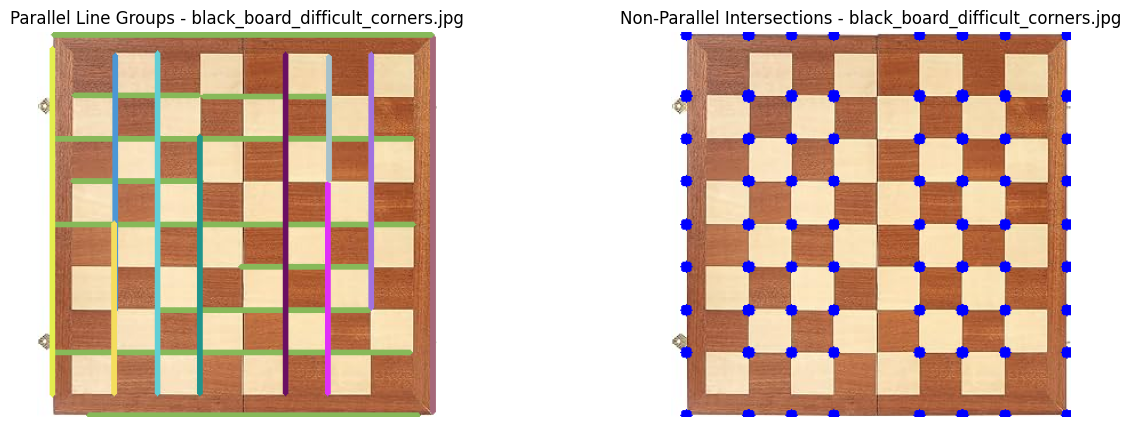

Non-parallel intersections found in data/boards/board_tilted.jpg: 13350


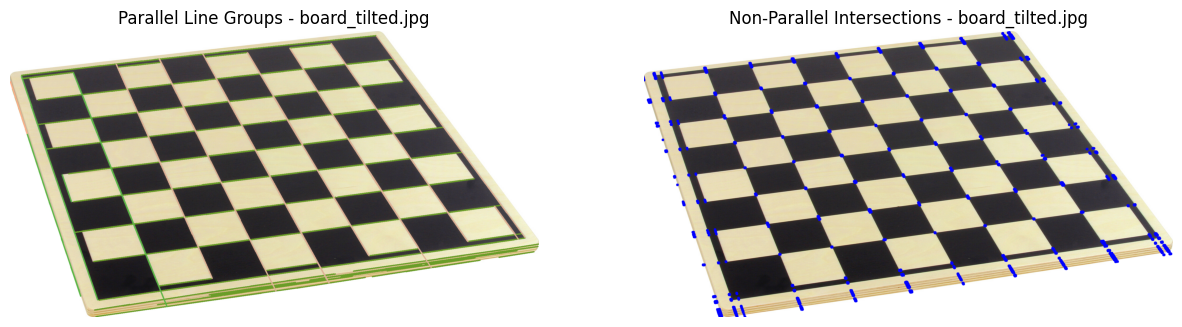

Non-parallel intersections found in data/checkerboards/checkerboard.jpg: 59228


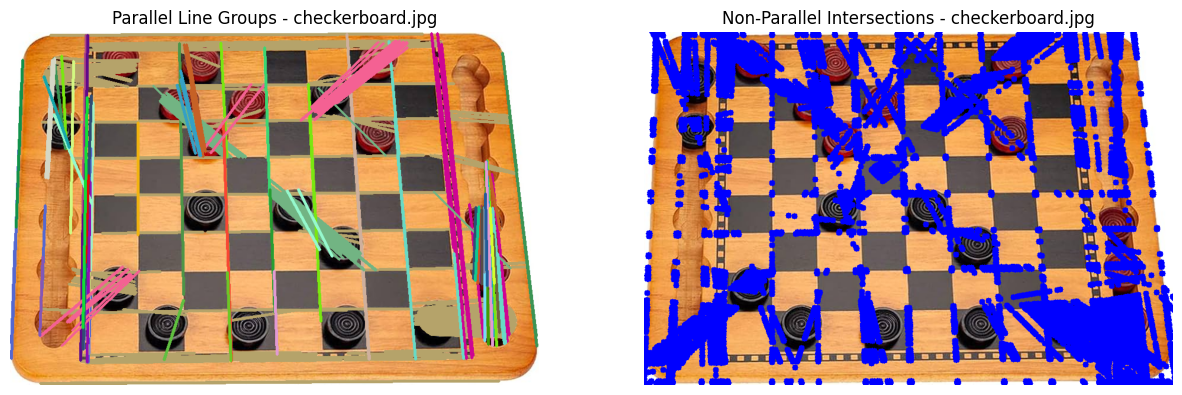

Non-parallel intersections found in data/checkerboards/checkerboard_with_pieces_tilted.jpg: 12584


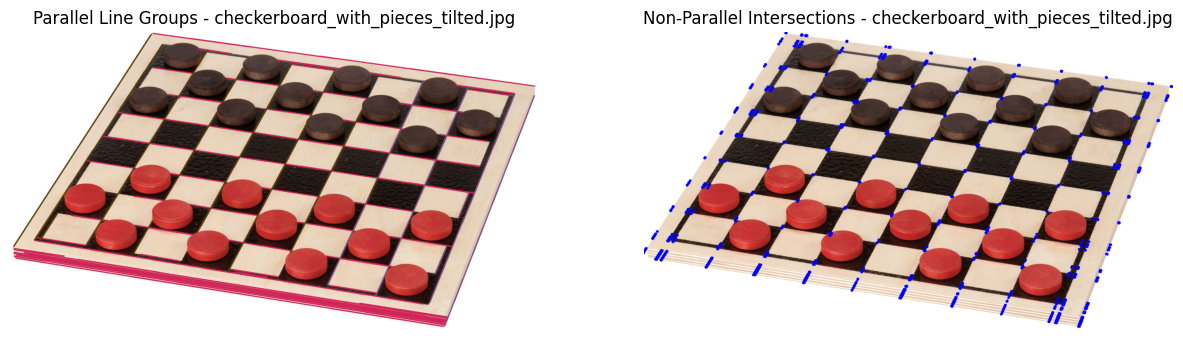

C:\Users\danim\AppData\Local\Temp\ipykernel_9184\2175471503.py:80: RuntimeWarning: overflow encountered in scalar multiply
  return a[0] * b[1] - a[1] * b[0]
C:\Users\danim\AppData\Local\Temp\ipykernel_9184\2175471503.py:80: RuntimeWarning: overflow encountered in scalar subtract
  return a[0] * b[1] - a[1] * b[0]


Non-parallel intersections found in data/chessboard/chessboard_with_pieces_tilted.PNG: 14514


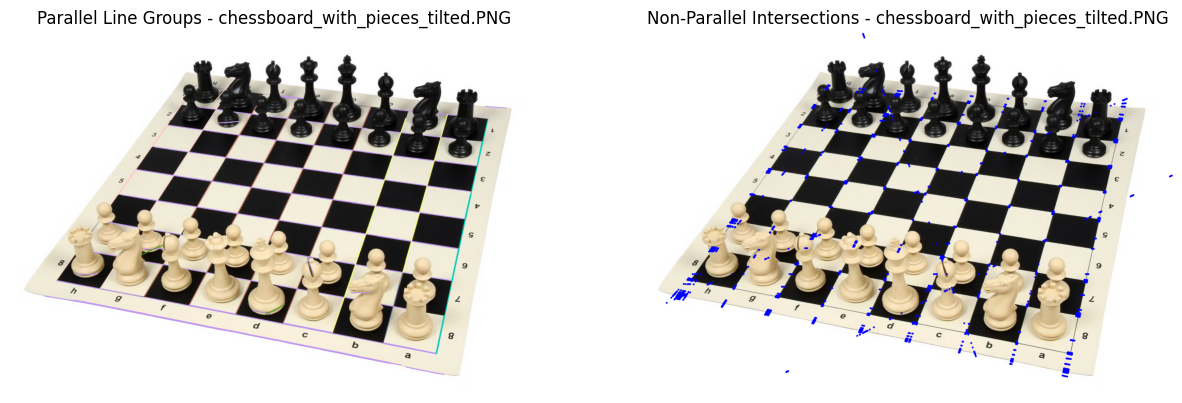

In [23]:
#iterative closest point between the points we want to find and the points we haven't found
# Plenty of code that does iterative closest point in python. Use a template and modify it to fit our needs

# List of image paths
image_paths = [
    'data/boards/black_board_difficult_corners.jpg',
    'data/boards/board_tilted.jpg',
    'data/checkerboards/checkerboard.jpg',
    'data/checkerboards/checkerboard_with_pieces_tilted.jpg',
    'data/chessboard/chessboard_with_pieces_tilted.PNG'
]

for image_path in image_paths:
    # 1. Read the image
    image = cv2.imread(os.path.relpath(image_path), cv2.IMREAD_COLOR)

    # 2. Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 3. Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # 4. Perform edge detection using the Canny edge detector
    edges = cv2.Canny(blurred, 50, 150)

    # 5. Use the Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=30, minLineLength=100, maxLineGap=30)

    # Ensure lines are detected
    if lines is None:
        print(f"No lines detected in {image_path}.")
        continue

    # 6. Function to calculate slope of a line
    def calculate_slope(x1, y1, x2, y2):
        if x2 - x1 != 0:
            return (y2 - y1) / (x2 - x1)
        else:
            return np.inf  # Vertical lines have infinite slope

    # 7. Group lines that are parallel by slope
    def group_parallel_lines(lines, slope_threshold=0.6):
        groups = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            slope = calculate_slope(x1, y1, x2, y2)
            added = False
            for group in groups:
                group_slope = calculate_slope(group[0][0], group[0][1], group[0][2], group[0][3])
                if abs(slope - group_slope) < slope_threshold:
                    group.append(line[0])
                    added = True
                    break
            if not added:
                groups.append([line[0]])
        return groups

    # 8. Group parallel lines
    parallel_groups = group_parallel_lines(lines)

    # 9. Display lines in different colors for each group
    grouped_image = image.copy()
    colors = []

    # Generate random colors for each group
    for _ in range(len(parallel_groups)):
        colors.append([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)])

    for i, group in enumerate(parallel_groups):
        for line in group:
            x1, y1, x2, y2 = line
            cv2.line(grouped_image, (x1, y1), (x2, y2), colors[i], thickness=4)

    # 10. Function to find intersection points between two lines
    def line_intersection(line1, line2):
        xdiff = (line1[0] - line1[2], line2[0] - line2[2])
        ydiff = (line1[1] - line1[3], line2[1] - line2[3])

        def det(a, b):
            return a[0] * b[1] - a[1] * b[0]

        div = det(xdiff, ydiff)
        if div == 0:
            return None  # Parallel lines

        d = (det((line1[0], line1[1]), (line1[2], line1[3])), 
             det((line2[0], line2[1]), (line2[2], line2[3])))
        x = det(d, xdiff) / div
        y = det(d, ydiff) / div
        return int(x), int(y)

    # 11. Find intersections between non-parallel lines only
    intersections = []
    for i, group1 in enumerate(parallel_groups):
        for line1 in group1:
            for j, group2 in enumerate(parallel_groups):
                if i != j:  # Avoid checking within the same group
                    for line2 in group2:
                        intersection = line_intersection(line1, line2)
                        if intersection:
                            intersections.append(intersection)

    print(f"Non-parallel intersections found in {image_path}: {len(intersections)}")

    # 12. Draw intersections as red dots on the original image
    intersections_image = image.copy()
    for intersection in intersections:
        cv2.circle(intersections_image, intersection, 5, (255, 0, 0), -1)  # Red for intersections

    # 13. Display the result with intersections
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(grouped_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f"Parallel Line Groups - {os.path.basename(image_path)}")
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(intersections_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title(f"Non-Parallel Intersections - {os.path.basename(image_path)}")
    axs[1].axis('off')


    plt.show()


Non-parallel intersections found in data/boards/reference_chessboard_pattern.jpg: 2810


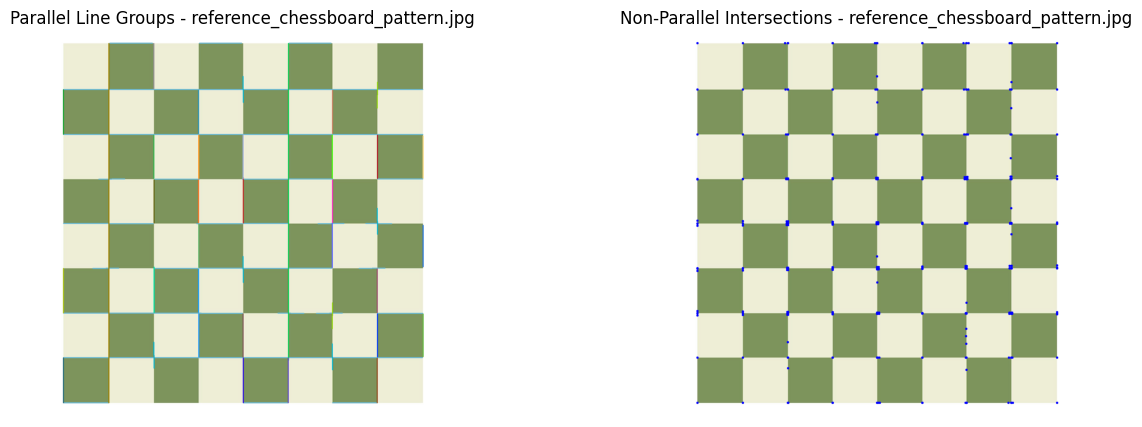

TypeError: object of type 'NoneType' has no len()

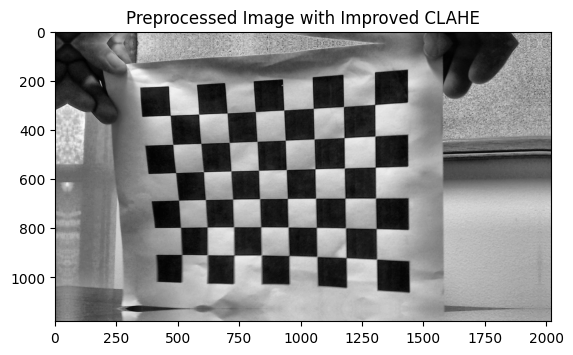

Chessboard corners not found in Calibration3DR0.jpg


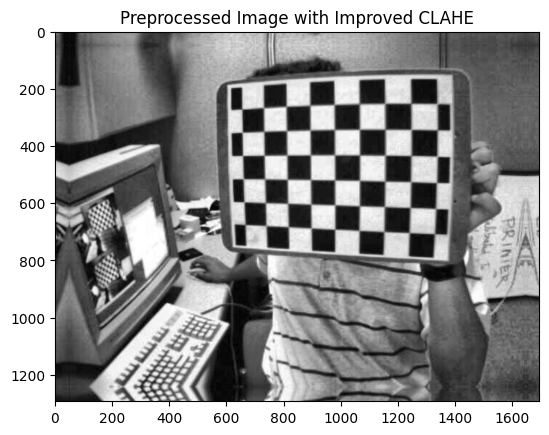

Chessboard corners not found in chessboard_corners_ex.JPG


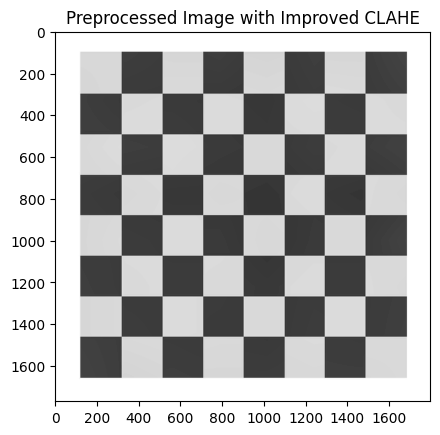

Chessboard corners not found in data/boards/reference_chessboard_pattern.jpg


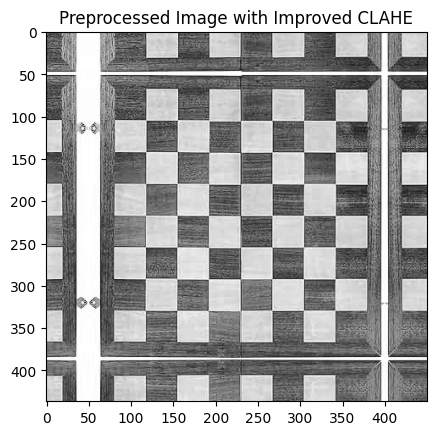

Chessboard corners not found in data/boards/black_board_difficult_corners.jpg


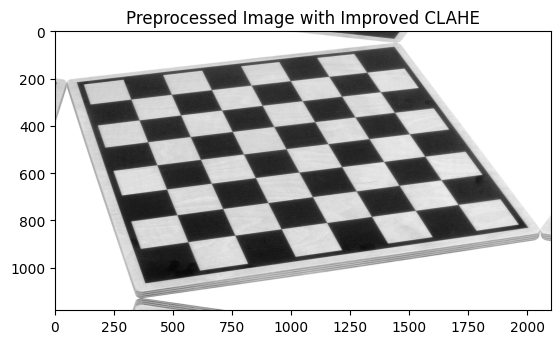

Chessboard corners not found in data/boards/board_tilted.jpg


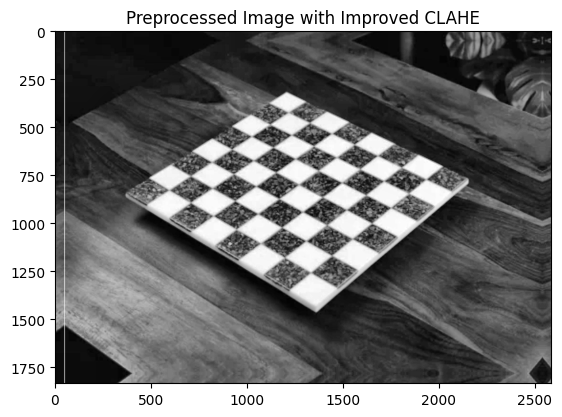

Chessboard corners not found in data/boards/irl_chessboard_1.JPG


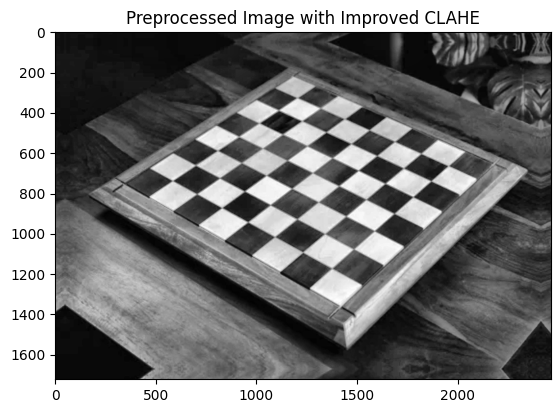

Chessboard corners not found in data/boards/irl_chessboard_2.JPG


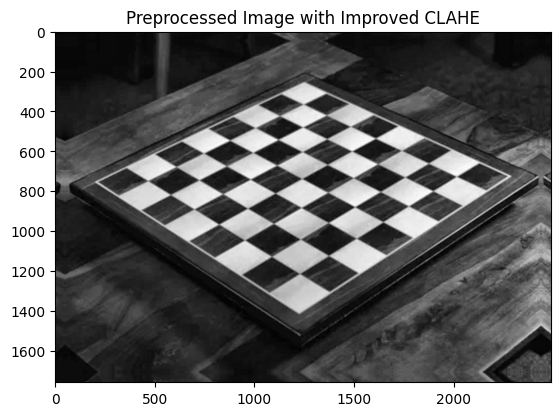

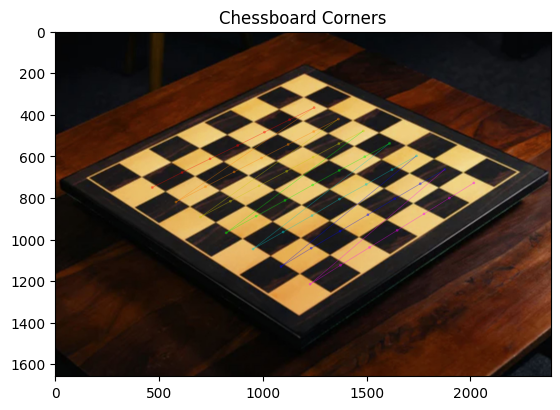

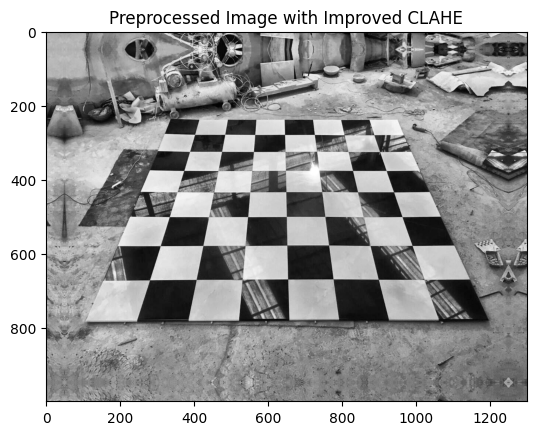

Chessboard corners not found in data/boards/irl_chessboard_4.JPG


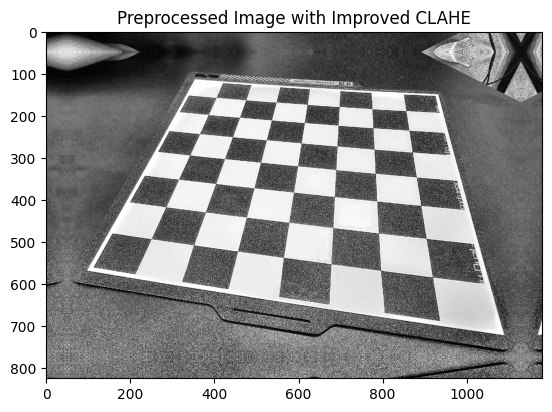

Chessboard corners not found in data/boards/irl_chessboard_5.JPG


In [ ]:
import cv2
import matplotlib.pyplot as plt

# List of image paths
image_paths = [
    'Calibration3DR0.jpg',
    'chessboard_corners_ex.JPG',
    'data/boards/reference_chessboard_pattern.jpg',
    'data/boards/black_board_difficult_corners.jpg',
    'data/boards/board_tilted.jpg',
    'data/boards/irl_chessboard_1.JPG',
    'data/boards/irl_chessboard_2.JPG',
    'data/boards/irl_chessboard_3.JPG',
    'data/boards/irl_chessboard_4.JPG',
    'data/boards/irl_chessboard_5.JPG',
]

for image_path in image_paths:
    # Read input image
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Pad it with 0's
    # improved = cv2.copyMakeBorder(gray, 50, 50, 50, 50, cv2.BORDER_REFLECT, value=0)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # improved = clahe.apply(improved)

    # Display the preprocessed image
    # plt.imshow(improved, cmap='gray')
    plt.imshow(gray, cmap='gray')
    plt.title("Preprocessed Image with Improved CLAHE")
    plt.show()

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7, 7), None)

    # If chessboard corners are detected
    if ret:
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7, 7), corners, ret)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Chessboard Corners")
        plt.show()
    else:
        print(f"Chessboard corners not found in {image_path}")


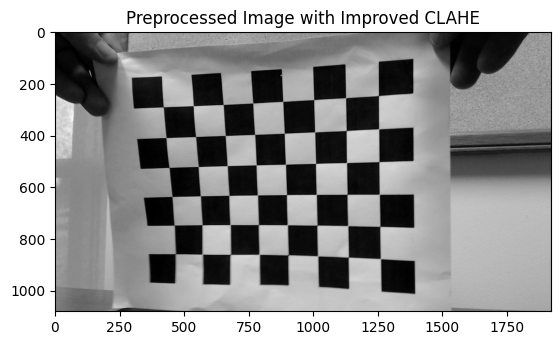

Chessboard corners not found in Calibration3DR0.jpg


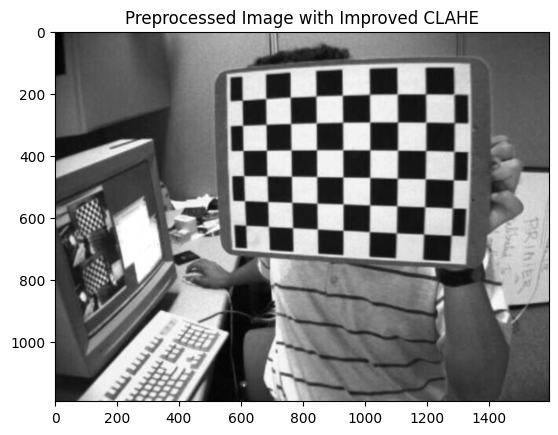

Chessboard corners not found in chessboard_corners_ex.JPG


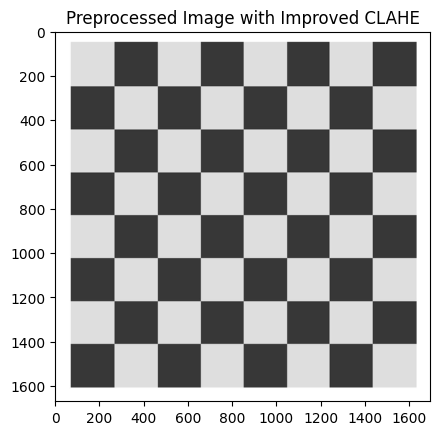

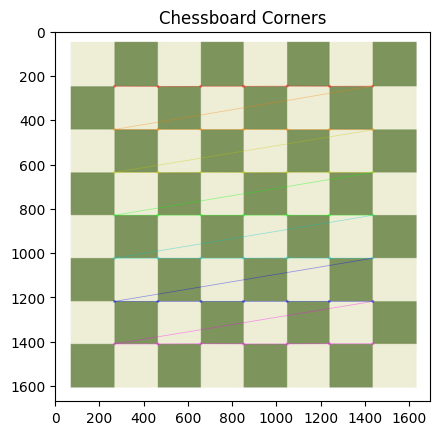

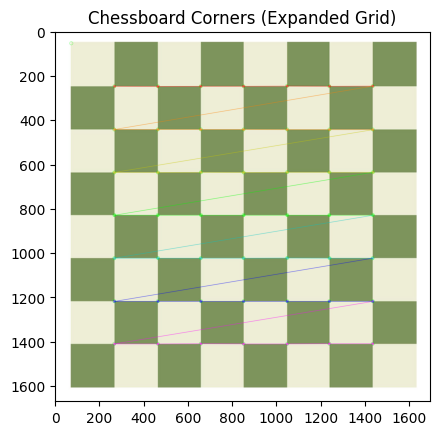

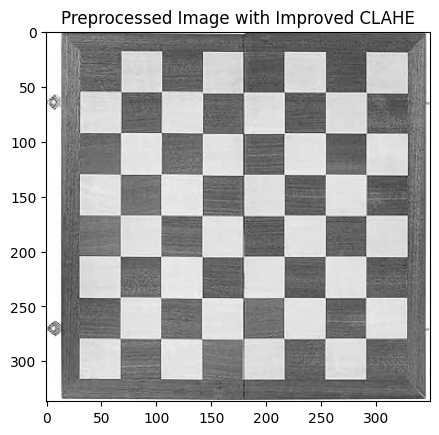

Chessboard corners not found in data/boards/black_board_difficult_corners.jpg


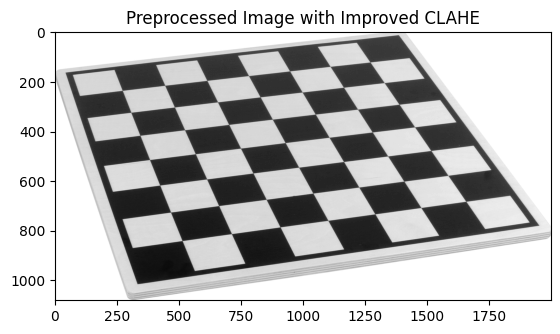

Chessboard corners not found in data/boards/board_tilted.jpg


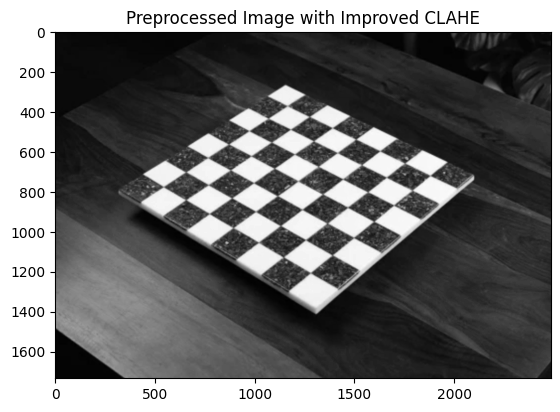

Chessboard corners not found in data/boards/irl_chessboard_1.JPG


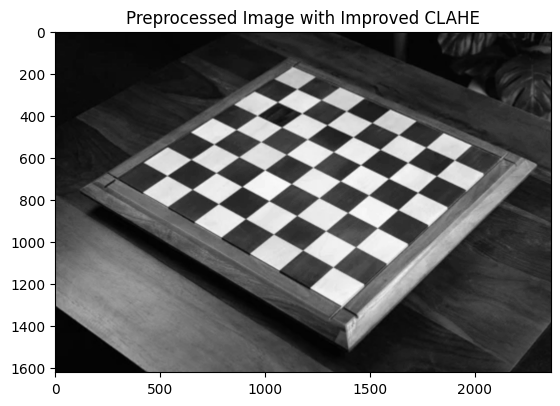

Chessboard corners not found in data/boards/irl_chessboard_2.JPG


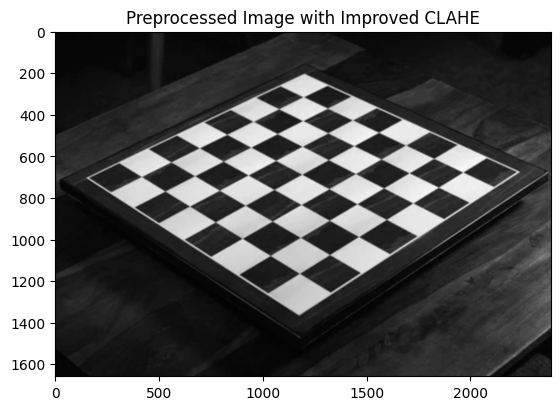

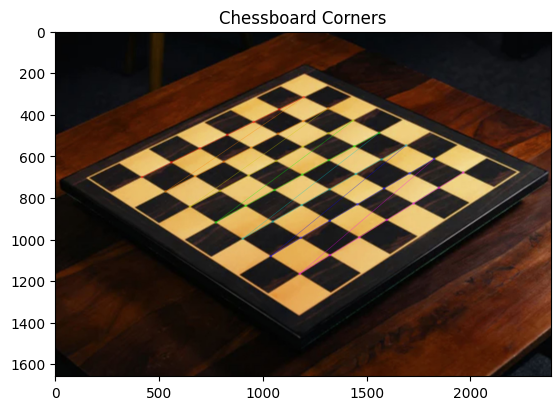

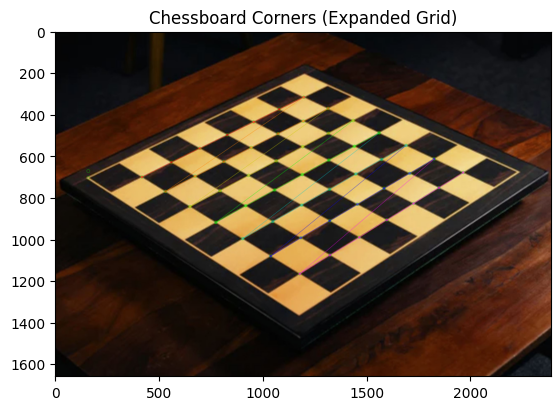

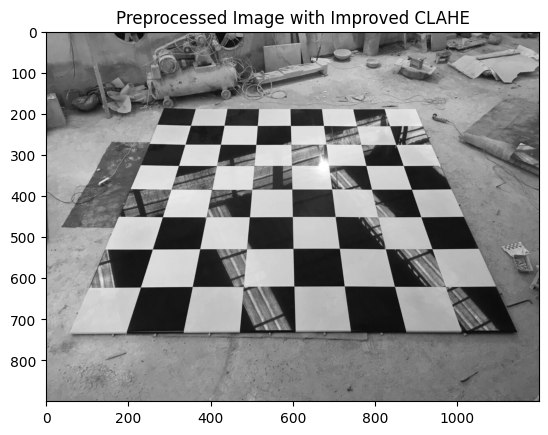

Chessboard corners not found in data/boards/irl_chessboard_4.JPG


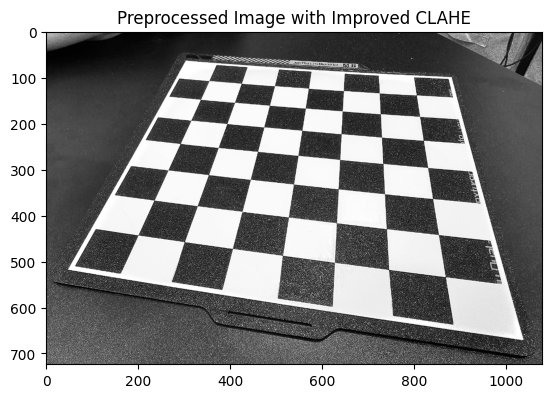

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# List of image paths
image_paths = [
    'Calibration3DR0.jpg',
    'chessboard_corners_ex.JPG',
    'data/boards/reference_chessboard_pattern.jpg',
    'data/boards/black_board_difficult_corners.jpg',
    'data/boards/board_tilted.jpg',
    'data/boards/irl_chessboard_1.JPG',
    'data/boards/irl_chessboard_2.JPG',
    'data/boards/irl_chessboard_3.JPG',
    'data/boards/irl_chessboard_4.JPG',
    'data/boards/irl_chessboard_5.JPG',
]

for image_path in image_paths:
    # Read input image
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Pad it with 0's
    # improved = cv2.copyMakeBorder(gray, 50, 50, 50, 50, cv2.BORDER_REFLECT, value=0)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # improved = clahe.apply(improved)

    # Display the preprocessed image
    # plt.imshow(improved, cmap='gray')
    plt.imshow(gray, cmap='gray')
    plt.title("Preprocessed Image with Improved CLAHE")
    plt.show()

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7, 7), None)

    # If chessboard corners are detected
    if ret:
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7, 7), corners, ret)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Chessboard Corners")
        plt.show()

        # Reshape corners for easier manipulation
        corners = corners.squeeze()

        # Calculate step vectors (average distance between adjacent corners)
        step_x = (corners[-1][0] - corners[0][0]) / 6
        step_y = (corners[-1][1] - corners[0][1]) / 6

        # Expand grid by predicting external corners
        expanded_corners = []

        for dy in [-1, 8]:  # Top and bottom rows
            for dx in [-1, 8]:  # Left and right columns
                x = corners[0][0] + dx * step_x
                y = corners[0][1] + dy * step_y
                expanded_corners.append((x, y))

        # Combine original and expanded corners
        all_corners = np.vstack((corners, expanded_corners))

        # Draw the expanded corners
        for corner in all_corners:
            cv2.circle(img, tuple(int(x) for x in corner), 8, (0, 255, 0), -1)

        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Chessboard Corners (Expanded Grid)")
        plt.show()
    else:
        print(f"Chessboard corners not found in {image_path}")
